# Test: 機械学習モデルを評価する

## なにをするのか

Trainで作成したモデルがBusiness Understandingで定義した価値を生むか、モデル、サービス、システムのレベルで確認します。

![test_001.PNG](images/06_test_001.PNG)

モデルのレベルでは機械学習モデルの性能・頑健性などについてテストします。モデル単体ではなく、学習に使うデータ、データを処理するプロセスなどモデルが生成されるまでの一連をテストします。

サービスレベルの「サービス」は、マイクロサービスにおける「サービス」と同義です。APIなどを通じモデルの予測を実行するためのエンドポイントをテストします。モデルを正しく呼び出せているかだけでなく、レスポンス性能などサービスレベルのテストも行います。

システムレベルは、プロダクトの機能としてのテストです。システム的なテストをシステムテスト、ユーザービリティをABテストなどでテストします。

3つのレベルは一般的な単体・結合・システムテストのレベルに対応します。機械学習モデルのテストは既存のプログラムと異なるテストが必要ですが、テストの考え方が変わってしまうわけではありません。

## なぜやるのか

通常のソフトウェア開発(DevOps)と同様、機械学習モデルの開発(MLOps)でも品質を担保するためにテストが必要です。

## どうやるのか

テストのレベル、プロセスによってテスト手法が異なります。学習データに対してはスキーマ定義に即したデータが入力されているかを[Deequ](https://github.com/awslabs/deequ)などでテストできます。データ処理は通常のプログラムなので、単体テストなどでテストできます。モデルについては特に機械学習ならではの評価が必要になります。そのため、プログラミング演習ではモデルのテストに焦点を当てPythonで行う方法を解説します。

![test_001.PNG](images/06_test_002.PNG)

コミュニケーション演習では、テストの実施に当たり関係者に行うべき依頼事項を確認します。

### プログラミング演習

#### モデルの性能

モデルの性能を評価する指標は、どのようなモデルかによって異なります。今回は価格を予測する回帰の問題であるため、予測と実際の値との差の平均である**二乗平均平方根誤差(RMSE)**、モデルのあてはまりの良さを0から1の値で表す **決定係数(R2)** を用います。数学的な定義は本記事では割愛するため、興味のある方はReferencesを参照してください。

予測と実際の値との差の平均であるRMSEを計算してみましょう。はじめにテスト用のデータ、前処理用のエンコーダーを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd


test_data_path = Path("../data/interim/test.csv")
test_df = pd.read_csv(test_data_path)

In [2]:
from pathlib import Path
from joblib import load


class Preprocessor():
    pass

encoder = load(Path("../model/encoder.joblib"))

モデルを読み込みます。

In [3]:
model = load(Path("../model/model.joblib")) 
other_model = load(Path("../model/other_model.joblib"))  

評価用データとモデルを受け取り、予測を行うための関数を定義します。予測する値は前処理、標準化された値なので元の平均・分散に戻す必要があるのに注意が必要です。

In [4]:
def predict(test_df, model, prediction_name="SalePricePredicted"):
    # 評価用データに対する前処理
    preprocessed = encoder.transform(test_df)
    preprocessed_df = pd.DataFrame(preprocessed, columns=test_df.columns)

    # 特徴と予測値に分離    
    X = preprocessed_df.drop("SalePrice", axis=1)

    prediction = model.predict(X)
    
    # 予測値は標準化された予測値なので、元の平均・分散に戻す
    inversed_y = encoder.named_transformers_["predictor_scaler"].inverse_transform(
                    prediction.reshape((-1, 1)))

    # 予測値を元のデータに加える
    prediction_df = test_df.copy()
    prediction_df[prediction_name] = inversed_y.flatten()

    return prediction_df

関数を使い、予測を行ってみます。

In [5]:
prediction_df = predict(test_df, model)
prediction_df[["SalePrice", "SalePricePredicted"]]

,SalePrice,SalePricePredicted
0,190000,201393.087709
1,173000,166002.869033
2,392500,229929.537645
3,181000,188905.174873
4,284000,226728.834312
...,...,...
433,278000,222732.498305
434,108959,128096.803375
435,128500,138855.485996
436,177500,160627.163792


RMSEを計算してみましょう。`scikit-learn`では、`mean_squared_error`を`squared=False`にすることで計算できます。

In [6]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(prediction_df["SalePrice"], prediction_df["SalePricePredicted"], squared=False)
print(f"Mean squared error is {rmse}")

Mean squared error is 38785.23991113922


4万ドルの差異は小さくないように思えます。0から1の間でモデルのあてはまりの良さを表す決定係数も算出してみましょう。

In [7]:
from sklearn.metrics import r2_score


r2 = r2_score(prediction_df["SalePrice"], prediction_df["SalePricePredicted"])
print(f"R2 score is {r2}")

R2 score is 0.7110819143398165


決定係数を見ても、まだ改善の余地はありそうです。複数の指標でモデルを評価することで、モデルの性質をよりよく理解することができます(分類のモデルでは、精度だけでなく適合率や再現率といった指標を確認します)。

予測(`SalePricePredicted`)と実際(`SalePrice`)のヒストグラムを重ねると、実際の価格より高めに予測されていることがわかります。

<AxesSubplot:ylabel='Frequency'>

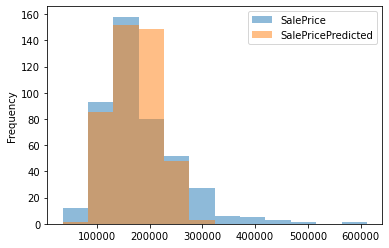

In [8]:
pd.concat([prediction_df["SalePrice"], prediction_df["SalePricePredicted"]], axis=1).plot.hist(bins=12, alpha=0.5)

*Exercise: もう片方のモデルでも性能を計測してみましょう*

In [9]:
prediction_other_df = predict(test_df, other_model)
rmse = mean_squared_error(prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"], squared=False)
r2 = r2_score(prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"])
print(f"Mean squared error is {rmse}")
print(f"R2 score is {r2}")

Mean squared error is 33066.61614237577
R2 score is 0.7899990439202026


<AxesSubplot:ylabel='Frequency'>

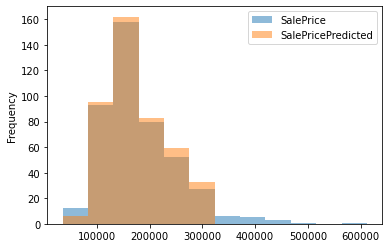

In [10]:
pd.concat([prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"]], axis=1).plot.hist(bins=12, alpha=0.5)

実際の価格の分布を正確に予測できていることがわかります。

「決定係数が0.86」という事実はモデルの性能評価の一つですが、プロダクトマネージャーやドメインエキスパートといったシステムレベルで評価したい方にはさっぱりです。システムレベルのテストを行うには、システムとして体験できるインタフェースの準備が必要です。開発環境のアプリケーションに組み込むのが一例ですが、困難な場合[Streamlit](https://streamlit.io/)などでデモ用のアプリケーションを構築する手段もあります。

一度「決定係数が0.8を超えているとつかえそう」ということがわかれば、それ以後は運用で決定係数が0.8を超えているかをモニタリングすべき指標として扱うことができます。

### コミュニケーション演習

プログラミング演習でモデルの性能を評価しました。モデルレベルでのテスト、またサービス・システムレベルでのテストを行うために誰に何を依頼すべきでしょうか。

ロールの種別

| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|----------------------------------------------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Engineer      | データエンジニア           | 機械学習モデルに入力可能なデータと特徴を作成する。                   |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |
| ML Engineer        | 機械学習エンジニア         | 機械学習モデルを本番環境にデプロイ可能な形式に変換する。             |
| ML Operator        | 業務担当者(機械学習側)     | 推論結果に基づき業務を行いつつ、フィードバックを与える。             |
| Model risk Manager | 機械学習モデルリスク管理者 | 機械学習モデルの推論の挙動を監視する。                               |
| MLOps Engineer     | MLOpsエンジニア            | 機械学習モデルの開発・運用プロセスを自動化する。                     |
| AI/ML Architect    | AI/MLアーキテクト          | 機械学習モデル開発に必要なアーキテクチャ全体を設計する。             |

依頼の種別

* 情報共有: 開発に必要な情報/ドキュメントの提供を依頼する
* 作業: 開発に必要な作業を分担(依頼)する
* レビュー: 作業の確度を上げるため/承認を得るためレビューを依頼する

![communication](images/communication.PNG)

#### MLOpsチームへの依頼例

モデルレベルのテストを行っている際は、Data Scientistに対して次の依頼をするとよいでしょう。

* レビュー
   * モデルの評価方法や評価結果についてレビューを依頼する。

#### DevOpsチームへの依頼例

サービスレベルのテストに移行する際は、DevOps EngineerやArchitectに対して次の依頼が必要でしょう。

* 作業依頼
   * Environment Setupで取り決めた環境構築手順書に沿ったうえで、機械学習モデルのサービス化を依頼する。
   * サービスレベルでのテストの実施。
   * A/Bテスト実行環境へのデプロイ。
* レビュー
   * モデルレベルのテスト結果

#### ビジネスチームへの依頼例

システムレベルのテストに移行する際は、Product ManagerやDomin Expertに次の依頼が必要でしょう。

* 作業依頼
   * A/Bテスト、ユーザビリティテストを行うためのユーザーの決定、召集。
   * テスト結果に基づく、今後のプロジェクトについての意思決定。
   * 上位のステークホルダーへのテスト結果と方針の説明。   
* レビュー
   * モデルレベルのテスト結果
   * サービスレベルのテスト結果
   * システムレベルのテスト結果

#### システム管理チームへの依頼例

IT Auditor、あるいはModel risk Managerがいれば、次の依頼をするとよいでしょう。いなければ、Product Managerか法務などに確認をします。

* レビュー
   * 機械学習を組み込んだシステムとしての法的適合性(医療の場合、医師法17条など([医療ＡＩと法的責任に関する研究](https://mhlw-grants.niph.go.jp/system/files/2018/181014/201804002A_upload/201804002A0008.pdf)))。
   * システムの振る舞いに対する社会的影響の評価。

## AWS Empowerment

SageMakerを使用することで、モデルのデプロイ、A/Bテストが行いやすくなります。各方法について次のドキュメントを参照してください。

* [モデルのデプロイ](https://sagemaker-examples.readthedocs.io/en/latest/inference/index.html#model-deployment)
* [A/Bテストの実施方法](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_endpoints/a_b_testing/a_b_testing.html)

## Next Step

[おわりに](../docs/ending.md)

## References

1. 佐藤直人, 小川秀人, 來間啓伸 and 明神智之. [AIソフトウェアのテスト](https://www.amazon.co.jp/dp/B095W5VGB3/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2021.
2. [QA4AI](https://www.qa4ai.jp/)
